(regression)=
# 回帰分析

回帰分析とは，データから二つの変数間の関係を求める手法です。説明変数$x$と目的変数$y$との関係が線型で表されると仮定すると
\begin{equation}
y = ax+b \label{ax+b}
\end{equation}
となります。回帰係数$a$と$b$を機械学習ライブラリ[scikit-learn](https://scikit-learn.org/)を使って求めてみましょう。

## 最小二乗法

　データとの誤差を最小にするには，分散が最小になるように回帰係数を決めます。これを最小二乗法と呼び，得られた回帰係数を最小分散推定量といいます。以下の例では，テストデータを作成して`sklearn.linear_model`の線型回帰`LinearRegression`を使っています。

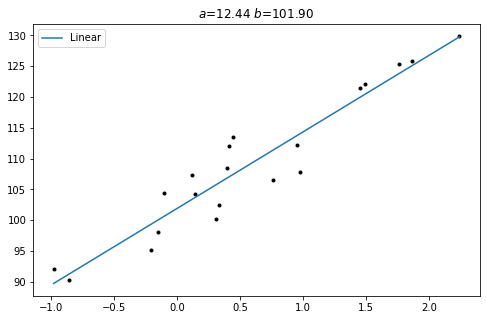

In [9]:
import numpy as np
import matplotlib.pyplot as plt
 
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
 
fig, ax = plt.subplots(figsize=[8,5])
 
rng = np.random.RandomState(0)
X, y = make_regression(n_samples=20, n_features=1, random_state=0,
                      noise=4.0, bias=100.0)
 
ax.plot(X, y, 'k.')
 
x = np.linspace(X.min(), X.max(), 7)
lin = LinearRegression()
lin.fit(X, y)
y_linear = lin.coef_ * x + lin.intercept_
ax.set_title(f"$a$={lin.coef_[0]:.2f} $b$={lin.intercept_:.2f}")
ax.plot(x, y_linear, label="Linear")
ax.legend()
plt.show()

* 4行目: `sklearn.dataset`から回帰用のデータを生成する`make_regression()`をインポートします。
* 5行目: `sklearn.linear_model`から線型回帰クラス`LinearRegression`をインポートします。
* 16行目: `LinearRegression`のオブジェクトを作成します。
* 17行目: `.fit()`メソッドを呼び，線型回帰を実行します。
* 18行目: 傾き`.coef_`と切片`.intercept_`により回帰直線を求めます。

## 外れ値

実際のデータには直線から大きく外れた値が含まれることがあります。これを外れ値といいます。
最小二乗法は外れ値に大きく影響を受けます。

外れ値を4点含めて最小二乗法を適用してみます。

w/o outliers: a=12.44 b=101.90
w/ outliers: a=-4.36 b=112.32


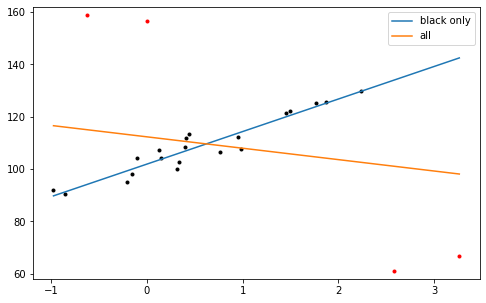

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, HuberRegressor

fig, ax = plt.subplots(figsize=[8,5])

rng = np.random.RandomState(0)
X, y = make_regression(n_samples=20, n_features=1, random_state=0,
                       noise=4.0, bias=100.0)
ax.plot(X, y, 'k.')
Xo = rng.normal(0, 0.5, size=(4, 1))
yo = rng.normal(0, 2.0, size=4)
Xo[:2, :] += X.max() + X.mean() / 4
Xo[2:, :] += X.min() - X.mean() / 4
yo[:2] += y.min() - y.mean() / 4
yo[2:] += y.max() + y.mean() / 4
X1 = np.vstack([X, Xo])
y1 = np.concatenate([y, yo])
ax.plot(Xo, yo, 'r.')

x = np.linspace(X1.min(), X1.max(), 7)
lin = LinearRegression()こ
lin.fit(X, y)
y_linear = lin.coef_ * x + lin.intercept_
print(f"w/o outliers: a={lin.coef_[0]:.2f} b={lin.intercept_:.2f}")
ax.plot(x, y_linear, label="black only")
lin.fit(X1, y1)
y_linear = lin.coef_ * x + lin.intercept_
print(f"w/ outliers: a={lin.coef_[0]:.2f} b={lin.intercept_:.2f}")
ax.plot(x, y_linear, label="all")
ax.set_ylim([58, 162])
ax.legend()
plt.show()

外れ値なしのとき傾きは正（$a=12.44$）でしたが, わずか4点外れ値が入るだけで負（$a=-4.36$）になってしまいます（橙色の実線）。
これは外れ値に近づけた方が全体として分散の和が最も小さくなるからです。

二つの変数の適切な関係を得るために，通常外れ値は除去してから最小二乗法を適用します。ここで問題となるのは，どれだけ外れたものを除去すれば良いかということです。またビッグデータには質の悪い値が混入するする可能性があり，個別に閾値を設け一つ一つ取り除くのは現実的ではありません。さらに厄介なのは，外れ値が意味を持つ場合です。例えば，発達した低気圧や台風の中心が観測点を通過し，周りに比べて低い気圧を観測した場合が該当します。観測網やモデルの解像度が粗い場合は，たまたま観測できた中心気圧は観測点含む領域を代表する値ではない，つまり代表性誤差があるデータとみなされます。一方中心気圧は顕著な現象を捉えた貴重なデータともいえます。

## ロバスト推定

最小二乗法のように推定を大きく変えることがなく，外れ値を含めた推定は可能でしょうか。外れ値の影響を受けにくい，ロバスト（頑強）推定という概念が{cite}`Huber:1964`により示されました。

外れ値が推定に大きな影響を与えてしまったのは，最小分散を得るために大きな重みを与えていたからです。裏返せば，値が外れるほど重みを小さくすればよいということになります。最小二乗法では分散つまり誤差の二乗を規準（ノルム）として誤差を評価しているため，乖離が大きくなると急激に値が大きくなります。二乗の代わりに絶対値をノルムとして用いると，変化は穏やかになります。0に近いところでは二乗，離れたところでは絶対値を用いたものをHuberノルムといいます。Huberノルムに基づくコスト函数を数式で表すと次のようになります。

\begin{equation}
J(\delta x) = 
\begin{cases}
\frac{1}{2}\frac{(\delta x)^2}{\sigma^2} &|\delta x| \le c\\
\frac{1}{2}\frac{c|\delta x|-c^2/2}{\sigma^2}& |\delta x| > c\\
\end{cases} \label{huberloss}
\end{equation}

ここで$J$はコスト函数，$\delta x$はデータとの乖離，$\sigma^2$は誤差分散，$c$は遷移点を表します。乖離の絶対値$|\delta x|$が$c$よりも大きいところでは1次函数，$c$以下では2次函数になっています。
函数をブロットして確認しましょう。

In [6]:
import numpy as np


def quadratic(x, sigmao=1):
    return 0.5 * (x / sigmao)**2

def huber(x, c, sigmao=1):
    absx = np.abs(x)
    rho = np.where(absx <= c,
        0.5 * (x / sigmao)**2,
        (c * (absx - 0.5 * c)) / sigmao**2)
    return rho

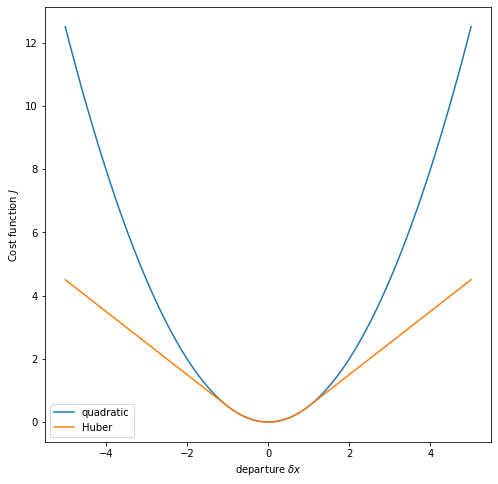

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=[8,8])

x = np.linspace(-5, 5, 101)

ax.plot(x, quadratic(x), label="quadratic")
ax.plot(x, huber(x, 1), label="Huber")
ax.set_xlabel("departure $\delta x$")
ax.set_ylabel("Cost function $J$")
ax.legend()
plt.show()

高収入の人を含めると，平均年収が高い方に引きずられることはよく知られていますが，外れ値は平均値にも大きく影響します。これに対し，データを順に並べたときに中位になる値である中央値はあまり影響を受けません。外れ値の影響を受けにくい推定手法をロバスト（robust，頑強）推定といいいます。Huberノルムを用いた回帰はロバスト推定の一つです。

scikit-learnの`sklearn.linear_model`の`LinearRegression`を`HuberRegressor`に替えて，遷移点を指定するとHuber回帰ができます。

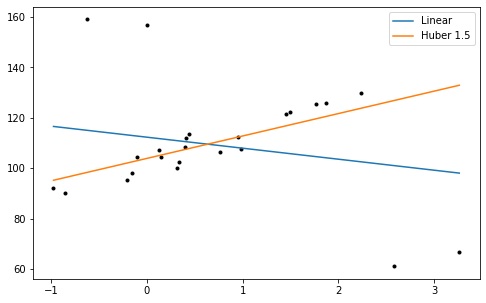

In [2]:
import numpy as np
import matplotlib.pyplot as plt
 
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, HuberRegressor
 
fig, ax = plt.subplots(figsize=[8,5])
 
rng = np.random.RandomState(0)
X, y = make_regression(n_samples=20, n_features=1, random_state=0,
                      noise=4.0, bias=100.0)
 
Xo = rng.normal(0, 0.5, size=(4, 1))
yo = rng.normal(0, 2.0, size=4)
Xo[:2, :] += X.max() + X.mean() / 4
Xo[2:, :] += X.min() - X.mean() / 4
yo[:2] += y.min() - y.mean() / 4
yo[2:] += y.max() + y.mean() / 4
X = np.vstack([X, Xo])
y = np.concatenate([y, yo])
ax.plot(X, y, 'k.')
 
x = np.linspace(X.min(), X.max(), 7)
lin = LinearRegression()
lin.fit(X, y)
y_linear = lin.coef_ * x + lin.intercept_
ax.plot(x, y_linear, label="Linear")
c = 1.5
hub = HuberRegressor(alpha=0.0, epsilon=c)
hub.fit(X, y)
y_huber = hub.coef_ * x + hub.intercept_
ax.plot(x, y_huber, label=f"Huber {c}")
ax.legend()
plt.show()

Huber回帰で得られた直線の傾きは$a=8.87$で，外れ値を除いた場合よりやや小さくなりましたが，外れ値の値を強く受けていないことが分かります。Huberノルムは，現業数値予報機関においてラジオゾンデデータ等現場観測の品質管理に用いられています。

## エルニーニョ現象

エルニーニョ現象は東太平洋赤道付近の海面水温が平年よりも高くなる現象です。
エルニーニョ現象が発生すると，日本は暖冬になることが多いとされています。
気象庁が発表している[監視指数](https://www.data.jma.go.jp/gmd/cpd/data/elnino/index/dattab.html)（5か月移動平均値）と冬季日本域の気温偏差との関係{cite}`Shiozaki-etal:2021`を調べてみます。

監視指数は処理しやすいCSV等では提供されていませんが，整形済みテキスト`pre`タグの中にデータがあるので，スクレイピングは非常に簡単です。
まず`requests.get()`でデータを取得します。
エンコーディングが正しくないので，`utf-8`にしていますが，データの部分に文字化けは影響しません。
BeautifulSoupの`html.parser`を使って`pre`タグを探し，テキストとして保存します。

In [1]:
import requests
from bs4 import BeautifulSoup


url = "https://www.data.jma.go.jp/gmd/cpd/data/elnino/index/nino3irm.html"
fname = "nino3.txt"
with requests.get(url) as response:
    response.encoding = "utf-8"
    soup = BeautifulSoup(response.text, "html.parser")
    with open(fname, "w") as f:
        f.write(soup.pre.text)

最初の行に月をヘッダとし，最初の列に年をインデックスとします。
年の列が5桁，データは6桁で，まだテータのない欠損値は`99.9`です。

In [2]:
import pandas as pd


df = pd.read_fwf(fname, widths=[5]+[6]*12, header=0, index_col=0, na_values=99.9)

`df`で中身を確認します。

In [3]:
df

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
year,,,,,,,,,,,,
1949,-0.2,-0.1,0.1,0.0,-0.2,-0.3,-0.5,-0.8,-0.9,-1.0,-1.2,-1.2
1950,-1.2,-1.0,-0.9,-0.8,-0.6,-0.6,-0.5,-0.4,-0.4,-0.4,-0.4,-0.3
1951,-0.2,-0.1,0.1,0.2,0.5,0.7,0.8,1.0,1.1,0.9,0.9,0.8
1952,0.6,0.5,0.4,0.1,-0.1,-0.2,-0.2,-0.2,-0.2,-0.1,0.0,0.1
1953,0.1,0.3,0.4,0.5,0.6,0.6,0.6,0.6,0.5,0.5,0.5,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...
2017,0.0,0.2,0.4,0.4,0.3,0.2,-0.1,-0.3,-0.5,-0.8,-1.0,-1.0
2018,-1.0,-0.9,-0.7,-0.4,-0.2,0.0,0.2,0.4,0.5,0.7,0.8,0.9
2019,0.9,0.8,0.7,0.6,0.5,0.3,0.1,0.0,0.0,0.1,0.2,0.2


1月，2月，12月を選び1次元の配列にします。

In [16]:
nino3 = df.loc[:"2020-12", ["Jan", "Feb", "Dec"]].to_numpy().flatten()

* 5行目: NCEP再解析データを取得します。
* 6行目: NINO.3に合わせて1949年1月からとし，850 hPa，東経120～東経150度，北緯50度～北緯20度を切り出します。
* 7行目: 12月，1月，2月（DJF）のみを残します。
* 8行目: 各格子点が代表する面積に比例するように，cos(緯度)の重みを掛けます。
* 9行目: 領域平均を計算します。
* 10行目: 月別気候値を計算します。
* 11行目: 線型トレンドを除去します。

In [18]:
import xarray as xr
from scipy.signal import detrend


ds = xr.open_dataset("https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/air.mon.mean.nc")
T = ds.air.loc["1949-01":"2020-12", 850, 50:20, 120:150]
T = T.loc[T.time.dt.season=="DJF"]
T *= np.cos(np.deg2rad(T.lat))
T = T.mean(["lat", "lon"])
Tc = T.groupby("time.month").mean("time")
Ta = detrend(T.groupby("time.month") - Tc)

データを散布図に描き，線型回帰とHuber回帰を行います。
どちらも傾きは正でNINO.3が大きいと暖冬傾向ですが，Huber回帰の方が傾きがやや大きくなりました。

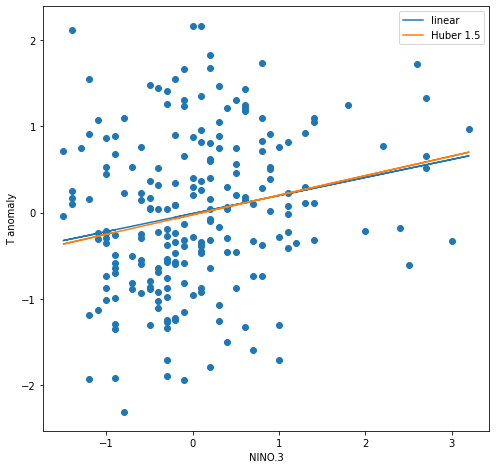

In [24]:
import matplotlib.pyplot as plt

from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, HuberRegressor

fig, ax = plt.subplots(figsize=[8, 8])
ax.scatter(nino3, Ta)

lin = LinearRegression()
lin.fit(nino3[:, None], Ta)
y_linear = lin.coef_ * nino3 + lin.intercept_
ax.plot(nino3, y_linear, label="linear")

c = 1.5
hub = HuberRegressor(alpha=0.0, epsilon=c)
hub.fit(nino3[:, None], Ta)
y_huber = hub.coef_ * nino3 + hub.intercept_
ax.plot(nino3, y_huber, label=f"Huber {c}")
ax.set(aspect=1, xlabel="NINO.3", ylabel="T anomaly")
ax.legend()
plt.show()